In [1]:
! pip install rasterio
! pip install earthpy
! pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.6 MB/s eta 0:00:00


In [2]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Parameters
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
N_CLASSES = 9
CLASSES = list(range(N_CLASSES))
PALETTE = ['#E00E42', '#393608', '#4c5ff9', '#77EEFC', '#6DFF86', '#E48C0A', '#BD10DD', '#11A21F', '#F9ED00']
SAMPLE_PATH = '/content/drive/MyDrive/DL/Samples_LC_2024.csv'
IMAGE_PATH = '/content/drive/MyDrive/DL/Landsat_2024.tif'

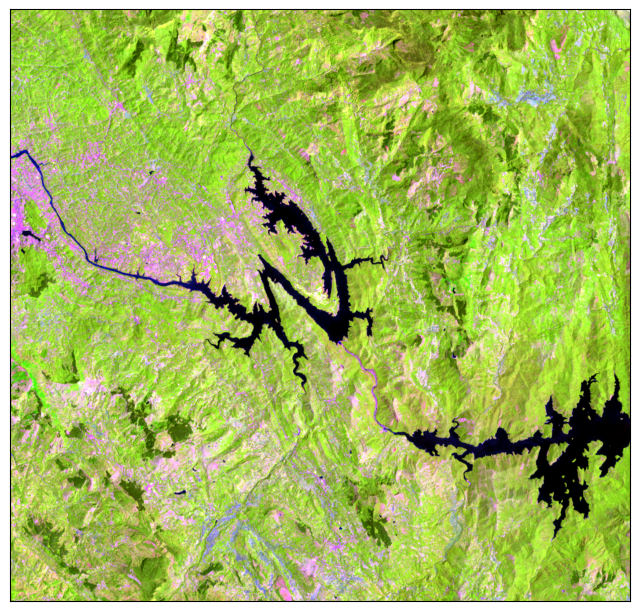

<Axes: >

In [4]:
# Load image
import rasterio
import numpy as np
import earthpy.plot as ep
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [7]:
import pandas as pd
# Load samples data
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac=1)  # shuffle
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
167,0.033365,0.039415,0.055131,0.043086,0.192301,0.114242,0.058046,0.322919,0.536275,0.254641,-0.554373,-0.254641,0.326175,434,4,train
227,0.022269,0.025211,0.047418,0.041917,0.275420,0.157335,0.082452,0.436342,0.539207,0.272868,-0.706245,-0.272868,0.312287,550,6,train
72,0.026091,0.028855,0.056767,0.042894,0.374846,0.216185,0.110530,0.586159,0.544560,0.268448,-0.736952,-0.268448,0.323386,1322,2,train
31,0.136077,0.153237,0.177657,0.191352,0.278225,0.350660,0.307733,0.170064,-0.050358,-0.115180,-0.220600,0.115180,0.065200,453,1,test
118,0.028525,0.031578,0.058912,0.054485,0.284770,0.206203,0.111905,0.418746,0.435785,0.160024,-0.657169,-0.160024,0.296433,1264,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.018955,0.022640,0.046565,0.028663,0.324288,0.143805,0.062872,0.557168,0.675212,0.385570,-0.748876,-0.385570,0.391588,453,4,train
97,0.011929,0.016122,0.028745,0.014143,0.021100,0.017181,0.012094,0.017658,0.271324,0.102367,0.153375,-0.102367,0.173783,233,3,train
298,0.029350,0.036307,0.075468,0.061140,0.300390,0.223390,0.117020,0.428787,0.439304,0.147008,-0.598425,-0.147008,0.312476,1047,7,test
186,0.018102,0.025005,0.059916,0.050827,0.301064,0.154901,0.076279,0.441025,0.595705,0.320556,-0.668036,-0.320556,0.340092,557,5,train


In [8]:
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

train_features = train[FEATURES].to_numpy()
train_label = train[LABEL].to_numpy() - 1  # shift labels 1->0
test_features = test[FEATURES].to_numpy()
test_label = test[LABEL].to_numpy() - 1

In [18]:

# Standardize features
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
scaler = StandardScaler()
train_input = scaler.fit_transform(train_features).reshape(train_features.shape[0], train_features.shape[1], 1)
test_input = scaler.transform(test_features).reshape(test_features.shape[0], test_features.shape[1], 1)

train_output = to_categorical(train_label, N_CLASSES)
test_output = to_categorical(test_label, N_CLASSES)

In [12]:
import pandas as pd
import numpy as np
import rasterio
from sklearn.preprocessing import StandardScaler #Scales features to zero mean and unit variance
from keras.utils import to_categorical #Converts integer labels to one-hot encoded vectors.
from keras import Sequential #build Conv1D deep learning model
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Input
from keras.callbacks import EarlyStopping #training optimization
import earthpy.plot as ep
from matplotlib.colors import from_levels_and_colors
import matplotlib.pyplot as plt


# Build a smaller Conv1D model
# ----------------------------
input_shape = (train_input.shape[1], train_input.shape[2])
model = Sequential([
    Input((14,1)),
    Conv1D(16, 2, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------------
# Train
# ----------------------------
stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
result = model.fit(train_input, train_output, validation_data=(test_input, test_output),
                   epochs=450, batch_size=32, callbacks=[stop])



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 13, 16)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.1155 - loss: 2.2464 - val_accuracy: 0.1525 - val_loss: 2.3265
Epoch 2/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1064 - loss: 2.2077 - val_accuracy: 0.1186 - val_loss: 2.2580
Epoch 3/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1426 - loss: 2.1695 - val_accuracy: 0.0678 - val_loss: 2.2144
Epoch 4/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1371 - loss: 2.1608 - val_accuracy: 0.1017 - val_loss: 2.1808
Epoch 5/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1701 - loss: 2.1222 - val_accuracy: 0.1017 - val_loss: 2.1571
Epoch 6/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1556 - loss: 2.1125 - val_accuracy: 0.1017 - val_loss: 2.1410
Epoch 7/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1804 - loss: 2.0825 - val_accuracy: 0.1017 - val_loss: 2.1297
Epoch 8/450
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1522 - loss: 2.0961 - val_accuracy: 0.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------------
# Reshape input for Conv2D
# -------------------------------------
train_input_2d = train_input.reshape(-1, 14, 1, 1)
test_input_2d  = test_input.reshape(-1, 14, 1, 1)

# -------------------------------------
# Build Conv2D model
# -------------------------------------
model = Sequential([
    Input((14, 1, 1)),
    Conv2D(16, (2, 1), activation='relu'),
    GlobalMaxPooling2D(),
    Dense(32, activation='relu'),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -------------------------------------
# Train
# -------------------------------------
stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

result = model.fit(
    train_input_2d, train_output,
    validation_data=(test_input_2d, test_output),
    epochs=200,
    batch_size=32,
    callbacks=[stop]
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 13, 1, 16)      │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_5          │ (None, 16)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.0709 - loss: 2.3422 - val_accuracy: 0.0678 - val_loss: 2.1447
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0403 - loss: 2.2844 - val_accuracy: 0.1864 - val_loss: 2.1445
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1018 - loss: 2.2032 - val_accuracy: 0.0847 - val_loss: 2.1578
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0589 - loss: 2.1765 - val_accuracy: 0.1186 - val_loss: 2.1637
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1533 - loss: 2.1514 - val_accuracy: 0.1017 - val_loss: 2.1926
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2002 - loss: 2.1356 - val_accuracy: 0.0678 - val_loss: 2.1869
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1794 - loss: 2.1087 - val_accuracy: 0.1356 - val_loss: 2.1885
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1829 - loss: 2.1070 - val_accuracy: 0.

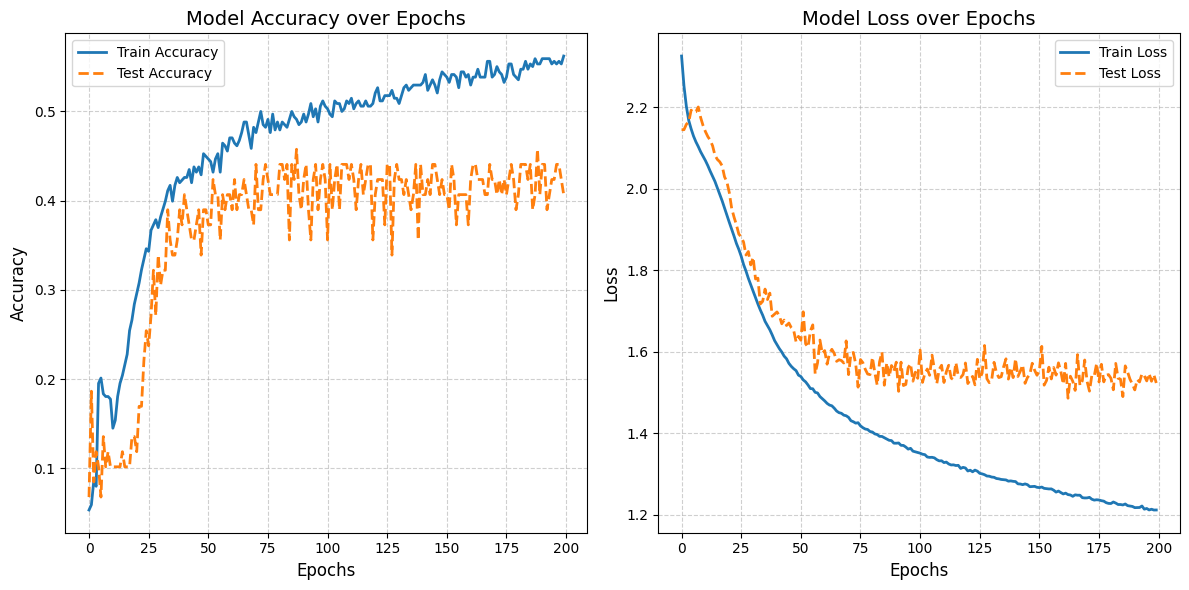

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert training history to DataFrame
history = pd.DataFrame(result.history)

# Create figure
plt.figure(figsize=(12, 6))

# -------------------------------
# Accuracy Plot
# -------------------------------
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Test Accuracy', linewidth=2, linestyle='--')
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# -------------------------------
# Loss Plot
# -------------------------------
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Test Loss', linewidth=2, linestyle='--')
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


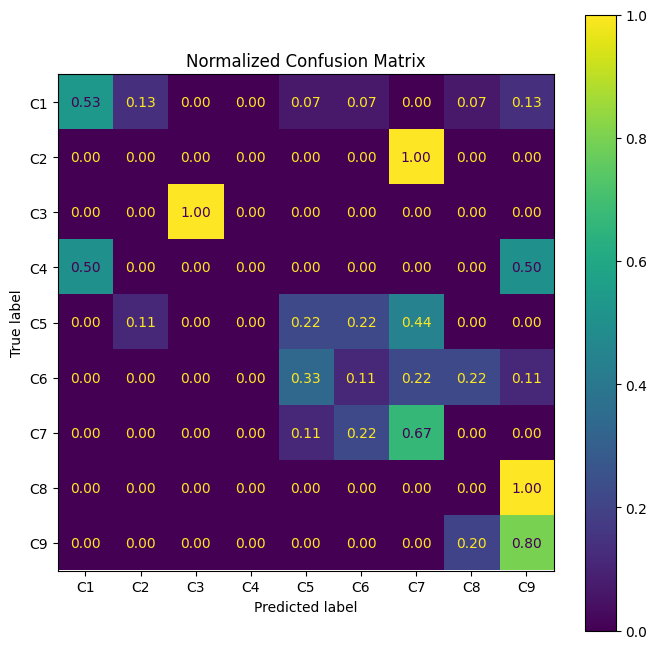


Classification Report:
              precision    recall  f1-score   support

           0      0.889     0.533     0.667        15
           1      0.000     0.000     0.000         4
           2      1.000     1.000     1.000         4
           3      0.000     0.000     0.000         2
           4      0.286     0.222     0.250         9
           5      0.167     0.111     0.133         9
           6      0.375     0.667     0.480         9
           7      0.000     0.000     0.000         2
           8      0.400     0.800     0.533         5

    accuracy                          0.424        59
   macro avg      0.346     0.370     0.340        59
weighted avg      0.454     0.424     0.414        59



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# ----------------------------
# Evaluate on test data
# ----------------------------
# Predict on test set
test_pred = np.argmax(model.predict(test_input), axis=1)
test_true = np.argmax(test_output, axis=1)

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(test_true, test_pred, normalize='true')  # normalized by class
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'C{i+1}' for i in range(N_CLASSES)])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='viridis', values_format=".2f", colorbar=True)
plt.title("Normalized Confusion Matrix")
plt.show()

# ----------------------------
# Classification Report
# ----------------------------
print("\nClassification Report:")
print(classification_report(test_true, test_pred, digits=3))

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


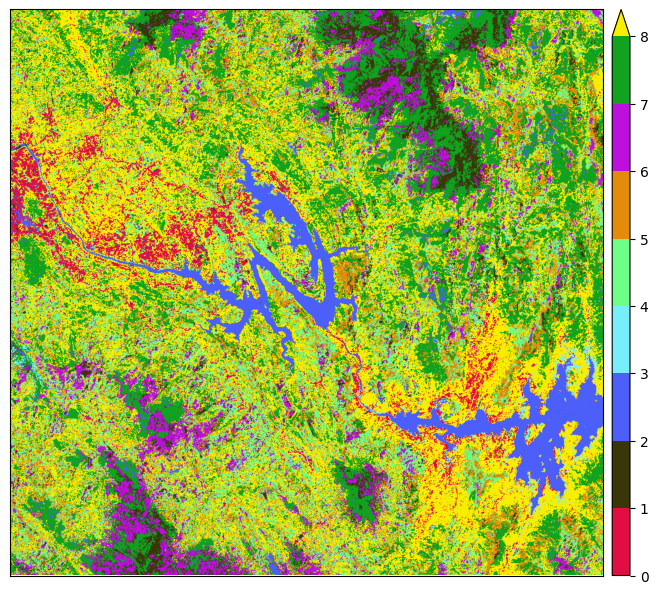

In [38]:
# ----------------------------
# Load raster image and prepare input
# ----------------------------
image = rasterio.open(IMAGE_PATH)
height, width = image.height, image.width
bands = []

for b in range(1, 15):  # 14 bands/features
    bands.append(image.read(b))
image_array = np.stack(bands, axis=0).reshape(14, -1).T  # (height*width, 14)
image_array_scaled = scaler.transform(image_array).reshape(-1, 14, 1)

# ----------------------------
# Predict image
# ----------------------------
prediction = model.predict(image_array_scaled, batch_size=4096)
prediction = np.argmax(prediction, axis=1)  # 0-8
prediction = prediction.reshape(height, width)  # reshape to image

# ----------------------------
# Plot
# ----------------------------
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(8, 8))
plt.show()


In [ ]:
# Save file to drive
save_location = '/content/drive/MyDrive/DL/'
name = 'LC_2024_tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()

In [42]:
# Final training and validation accuracy
final_train_acc = history['accuracy'].iloc[-1]
final_val_acc = history['val_accuracy'].iloc[-1]

print(f"Final Training Accuracy: {final_train_acc:.3f}")
print(f"Final Validation (Test) Accuracy: {final_val_acc:.3f}")


Final Training Accuracy: 0.562
Final Validation (Test) Accuracy: 0.407


In [43]:
test_loss, test_accuracy = model.evaluate(test_input, test_output, verbose=0)
print(f"Test Accuracy (evaluate): {test_accuracy:.3f}")
print(f"Test Loss: {test_loss:.4f}")


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>